In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
fernando2rad_brain_tumor_mri_images_44c_path = kagglehub.dataset_download('fernando2rad/brain-tumor-mri-images-44c')

print('Data source import complete.')


Data source import complete.


In [ ]:
import os
from PIL import Image
import itertools

import cv2
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout,BatchNormalization

import warnings
warnings.filterwarnings('ignore')

print('Modules Successfully Loaded')

Modules Successfully Loaded


In [ ]:
data_dir ="/kaggle/input/brain-tumor-mri-images-44c"
paths = []
labels = []
folds = os.listdir(data_dir)
for fold in folds :
    condition_path = os.path.join(data_dir,fold)
    all_pic = os.listdir(condition_path)
    for each_pic in all_pic:
        each_pic_path = os.path.join(condition_path,each_pic)
        paths.append(each_pic_path)
        labels.append(fold.split(' ')[0])

pseries = pd.Series(paths, name='Picture Path')
lseries = pd.Series(labels, name='Label')

df = pd.concat([pseries, lseries], axis =1)
df

,Picture Path,Label
0,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma
1,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma
2,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma
3,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma
4,/kaggle/input/brain-tumor-mri-images-44c/Papil...,Papiloma
...,...,...
4474,/kaggle/input/brain-tumor-mri-images-44c/Germi...,Germinoma
4475,/kaggle/input/brain-tumor-mri-images-44c/Germi...,Germinoma
4476,/kaggle/input/brain-tumor-mri-images-44c/Germi...,Germinoma
4477,/kaggle/input/brain-tumor-mri-images-44c/Germi...,Germinoma


In [ ]:
train_df, ts_df = train_test_split(df,test_size= 0.2,shuffle=True,random_state=42,stratify= df['Label'])
test_df, valid_df = train_test_split(ts_df,test_size= 0.5,shuffle=True,random_state=42, stratify= ts_df['Label'])
train_df


,Picture Path,Label
1595,/kaggle/input/brain-tumor-mri-images-44c/Tuber...,Tuberculoma
3844,/kaggle/input/brain-tumor-mri-images-44c/Medul...,Meduloblastoma
1347,/kaggle/input/brain-tumor-mri-images-44c/Astro...,Astrocitoma
2588,/kaggle/input/brain-tumor-mri-images-44c/Carci...,Carcinoma
1973,/kaggle/input/brain-tumor-mri-images-44c/Neuro...,Neurocitoma
...,...,...
1557,/kaggle/input/brain-tumor-mri-images-44c/Oligo...,Oligodendroglioma
4286,/kaggle/input/brain-tumor-mri-images-44c/Epend...,Ependimoma
597,/kaggle/input/brain-tumor-mri-images-44c/Neuro...,Neurocitoma
2712,/kaggle/input/brain-tumor-mri-images-44c/Epend...,Ependimoma


In [ ]:
batch_size = 32
img_size = (224,224)

gen = ImageDataGenerator()

train_gen = gen.flow_from_dataframe(train_df, x_col='Picture Path', y_col='Label',target_size= img_size, class_mode= 'categorical', color_mode='rgb', shuffle = True,batch_size= batch_size)

valid_gen = gen.flow_from_dataframe(valid_df, x_col='Picture Path', y_col='Label',target_size= img_size, class_mode= 'categorical', color_mode='rgb', shuffle = True,batch_size= batch_size)

test_gen = gen.flow_from_dataframe(test_df, x_col='Picture Path', y_col='Label',target_size= img_size, class_mode= 'categorical', color_mode='rgb', shuffle = False,batch_size= batch_size)

Found 3582 validated image filenames belonging to 15 classes.
Found 448 validated image filenames belonging to 15 classes.
Found 448 validated image filenames belonging to 15 classes.


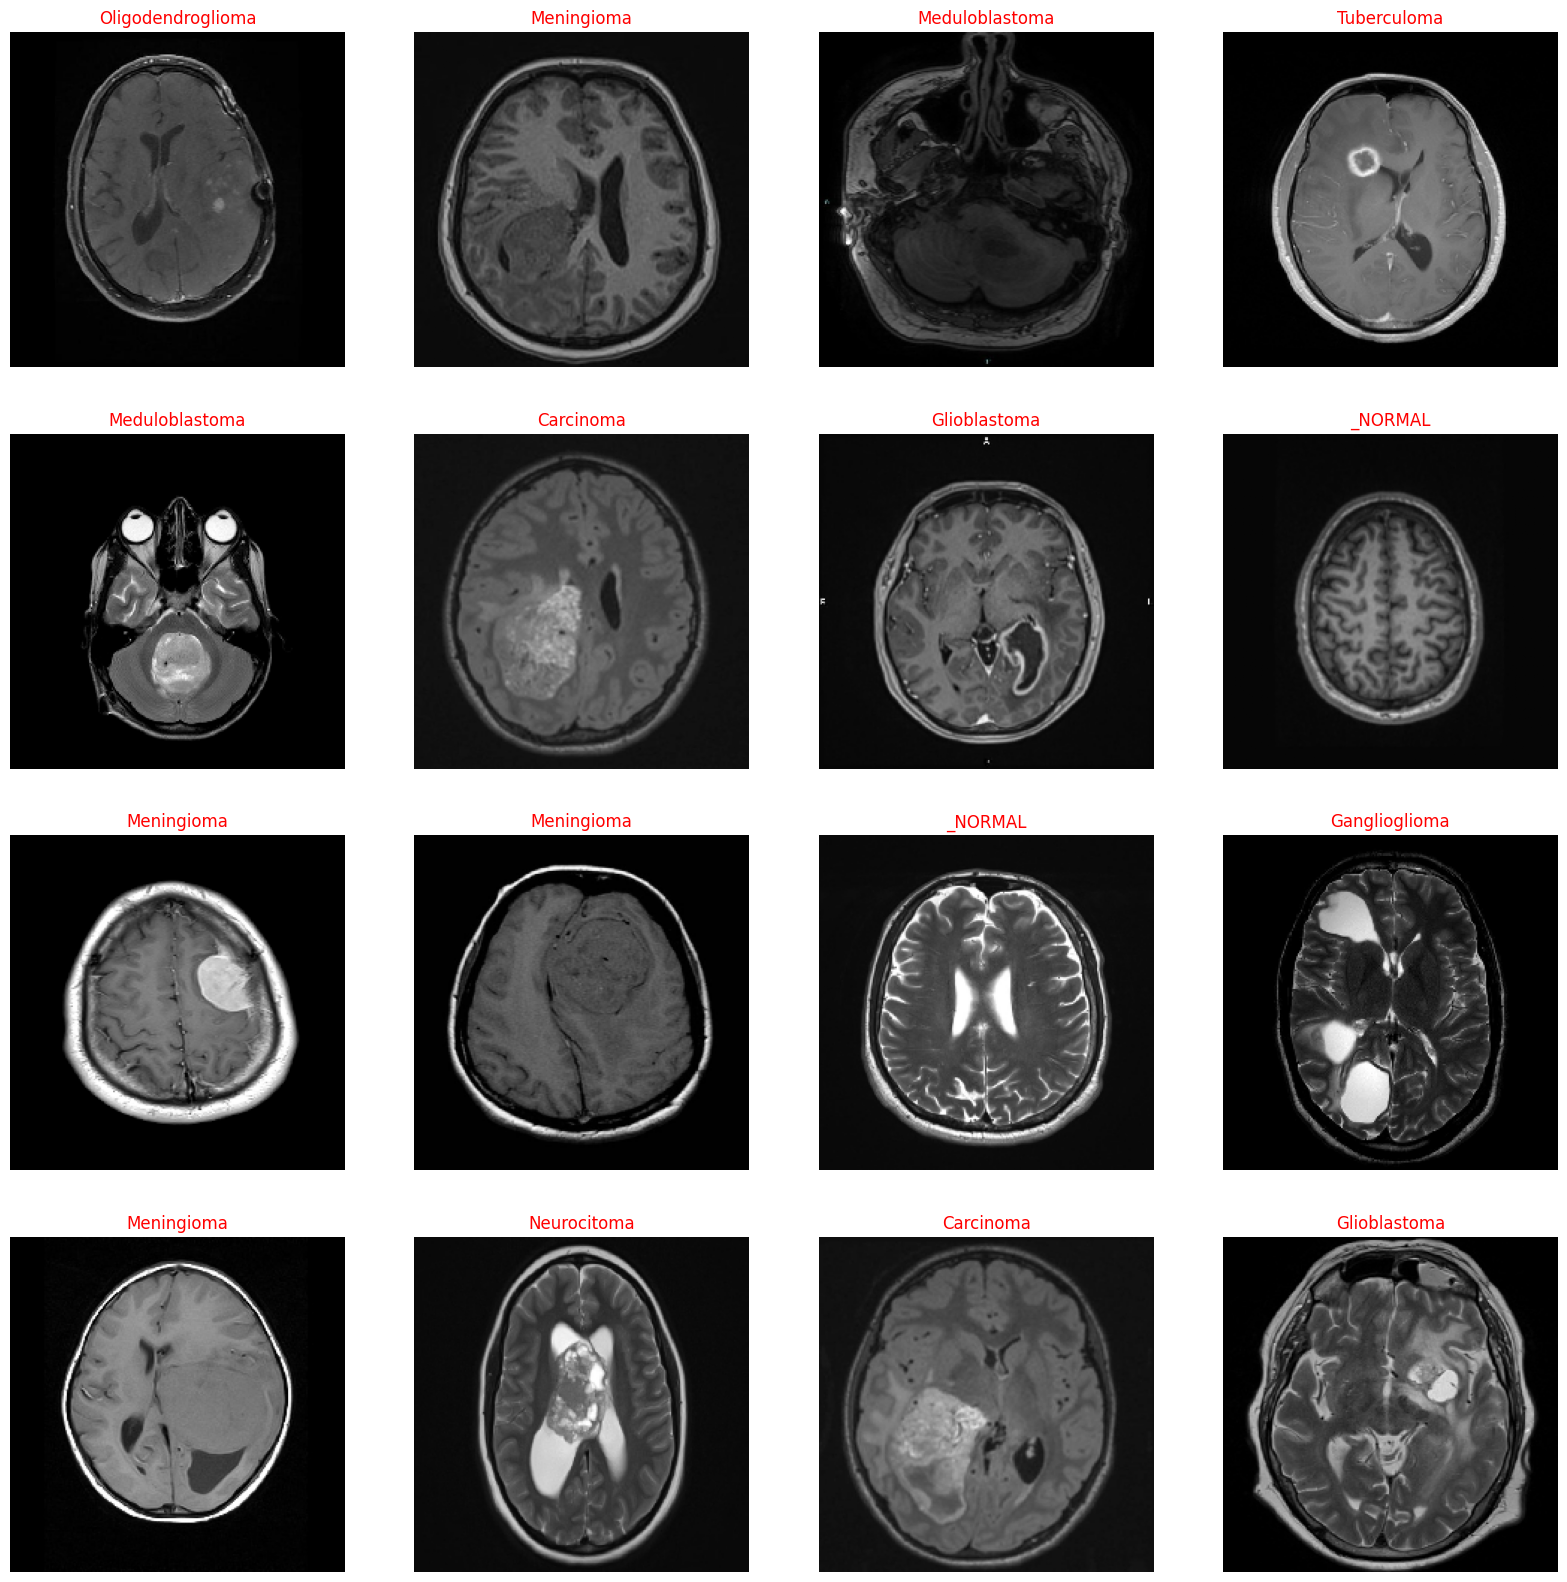

In [ ]:
g_dict = train_gen.class_indices
classes= list(g_dict.keys())

images, labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range (16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index= np.argmax(labels[i]) #[0,0,0,1,0]
    class_name = classes[index]
    plt.title(class_name,c='r', fontsize=12)
    plt.axis('off')
plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 26,876,463 (102.53 MB)

 Trainable params: 26,873,519 (102.51 MB)

 Non-trainable params: 2,944 (11.50 KB)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 94s 596ms/step - accuracy: 0.2899 - loss: 13.2904 - val_accuracy: 0.1339 - val_loss: 11.2146 - learning_rate: 0.0010
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.5643 - loss: 9.4766 - val_accuracy: 0.3750 - val_loss: 8.8065 - learning_rate: 0.0010
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 179ms/step - accuracy: 0.6992 - loss: 7.5284 - val_accuracy: 0.6696 - val_loss: 6.7439 - learning_rate: 0.0010
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 21s 183ms/step - accuracy: 0.7711 - loss: 6.1416 - val_accuracy: 0.7210 - val_loss: 5.6452 - learning_rate: 0.0010
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.8151 - loss: 5.1647 - val_accuracy: 0.7612 - val_loss: 4.9347 - learning_rate: 0.0010
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.8444 - loss: 4.4189 - val_accuracy: 0.8527 - val_loss: 4.0982 - learning_rate: 0.0010
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0

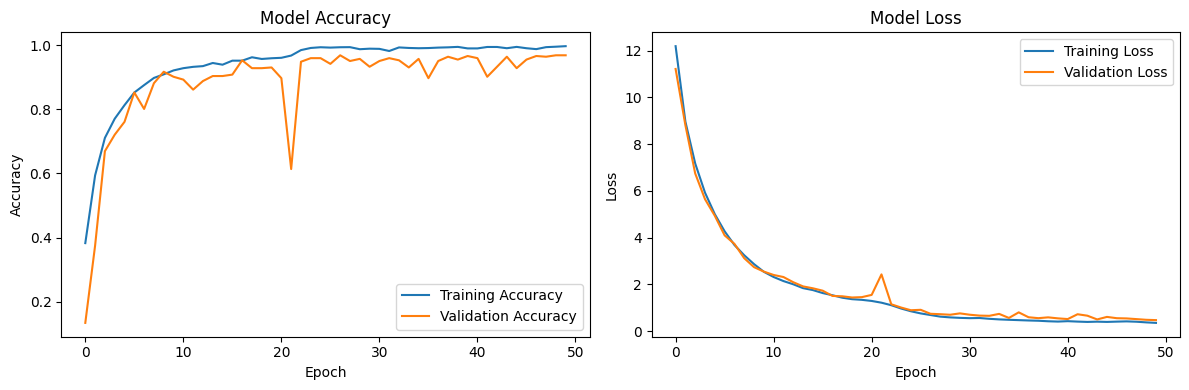

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 328ms/step - accuracy: 0.9701 - loss: 0.4862

Test Accuracy: 0.9621
Test Loss: 0.4946
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step


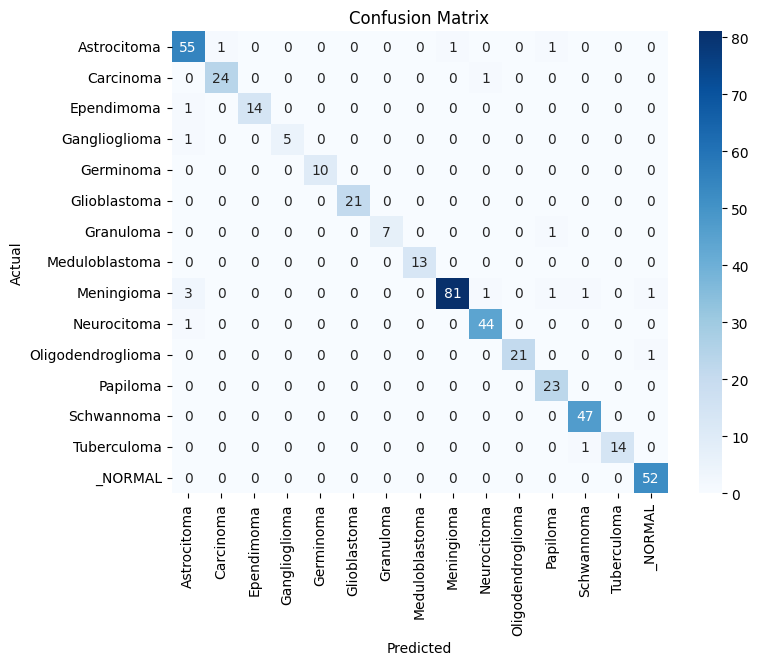


Classification Report:
                   precision    recall  f1-score   support

      Astrocitoma       0.90      0.95      0.92        58
        Carcinoma       0.96      0.96      0.96        25
       Ependimoma       1.00      0.93      0.97        15
    Ganglioglioma       1.00      0.83      0.91         6
        Germinoma       1.00      1.00      1.00        10
     Glioblastoma       1.00      1.00      1.00        21
        Granuloma       1.00      0.88      0.93         8
   Meduloblastoma       1.00      1.00      1.00        13
       Meningioma       0.99      0.92      0.95        88
      Neurocitoma       0.96      0.98      0.97        45
Oligodendroglioma       1.00      0.95      0.98        22
         Papiloma       0.88      1.00      0.94        23
       Schwannoma       0.96      1.00      0.98        47
      Tuberculoma       1.00      0.93      0.97        15
          _NORMAL       0.96      1.00      0.98        52

         accuracy             

In [ ]:
# Define the CNN model
def create_model():
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),

        # Fourth Convolutional Block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.5),

        # Classifier Head
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        BatchNormalization(),
        Dropout(0.6),
        Dense(len(classes), activation='softmax')
    ])

    return model

# Create and compile the model
model = create_model()

optimizer = Adamax(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6
)

# Train the model
epochs = 50
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f'\nTest Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

# Generate predictions
y_pred = model.predict(test_gen)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_gen.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=classes))

# Save the model
model.save('brain_tumor_classifier.h5')